In [40]:
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import pandas as pd
from datetime import datetime


In [29]:
import torch_directml

device = torch_directml.device()
print(f"device: {device}")

device: privateuseone:0


YOLOv8:

In [41]:
from ultralytics import YOLO

model_path = "yolov8s.pt"

try:
    model = YOLO(model_path)
    print("donwloaded")
    

except Exception as e:
    print(e)
    model = YOLO(model_path) 

100%|██████████| 21.5M/21.5M [01:09<00:00, 324kB/s]


donwloaded


предсказание на недообученной модели:

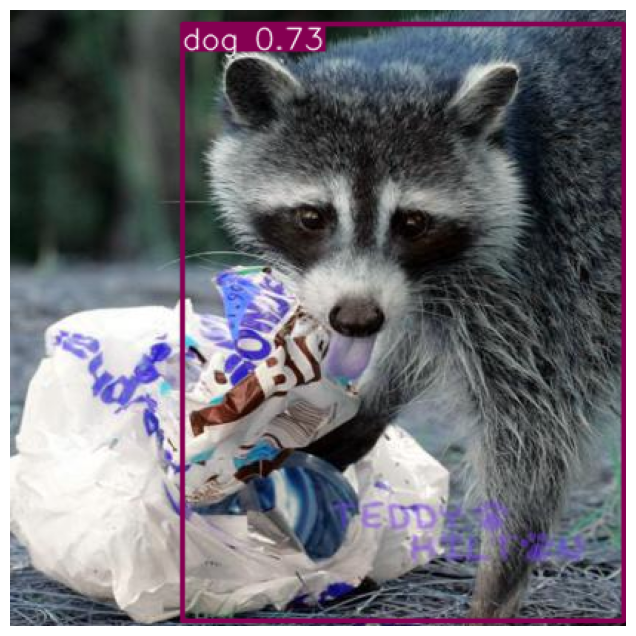

In [55]:
test_image_path = Path("../data/raw/train/images")
if test_image_path.exists():
    images = list(test_image_path.glob("*"))
    if images:
        img_path = images[10]
        
    
        results = model.predict(
            source=str(img_path),
            conf=0.3,      
            iou=0.5,      
            show_labels=True,
            show_conf=True,
            save=False,
            verbose=False
        )
        
      
        for r in results:
            im_array = r.plot() 
            plt.figure(figsize=(10, 8))
            plt.imshow(im_array)
            plt.axis('off')
            plt.show()
        


конфиги YOLO:

In [20]:
import ultralytics
print(Path(ultralytics.__file__).parent / "cfg" / "models")
    

c:\Users\Professional\AppData\Local\Programs\Python\Python311\Lib\site-packages\ultralytics\cfg\models


In [23]:
model.model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

backbone 0-9 
neck 10-21
head 22

заморозка backbone и первых 5 слоев neck

In [44]:
#model = model.to(device)
model.model.train()

for i, (name, param) in enumerate(model.model.named_parameters()):
        print(param.requires_grad)
    

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

все слои заморожены изначально, разморзка с 15 по конец:

In [43]:
def get(name):
    parts = name.split('.')
    if parts[0] == 'model':
        return int(parts[1])
    return -1

for name, param in model.model.named_parameters():
    layer_num = get(name)
    if layer_num >= 15:
        param.requires_grad = True
        


train:

In [45]:

mod = model.train(
    data='../data/raw/data.yaml',  
    epochs=50,
    imgsz=416,
    batch=8,
    patience=30,
    device='cpu', 
    
    lr0=0.001,
    lrf=0.01,
    weight_decay=0.0005,  #L2 
    optimizer='Adam',
    

    augment=True,
    hsv_h=0.02,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=15,
    fliplr=0.5,
    translate=0.1,
    scale=0.3,
    
    save=True,
    project='detection',
    name='frozen',
    exist_ok=True,
    plots=True,
    verbose=True
)



Ultralytics YOLOv8.1.0 🚀 Python-3.11.9 torch-2.4.1+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=../data/raw/data.yaml, epochs=50, time=None, patience=30, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=detection, name=frozen, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

train: Scanning C:\Users\Professional\detection\data\raw\train\labels... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 1744.21it/s]

train: New cache created: C:\Users\Professional\detection\data\raw\train\labels.cache



val: Scanning C:\Users\Professional\detection\data\raw\valid\labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 2071.51it/s]

val: New cache created: C:\Users\Professional\detection\data\raw\valid\labels.cache


Plotting labels to detection\frozen\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.509      1.747      1.778         20        416: 100%|██████████| 19/19 [00:48<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]

                   all         29         29      0.765      0.655      0.716      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G       1.48      1.433      1.682         15        416: 100%|██████████| 19/19 [00:47<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]

                   all         29         29       0.74      0.759      0.749      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.468      1.416      1.695         11        416: 100%|██████████| 19/19 [00:48<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]

                   all         29         29       0.67      0.909      0.815      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.464      1.459      1.728         16        416: 100%|██████████| 19/19 [00:52<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

                   all         29         29      0.846      0.948      0.934      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.535      1.404      1.747         17        416: 100%|██████████| 19/19 [00:37<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all         29         29      0.682      0.897      0.891      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.447      1.438      1.696         13        416: 100%|██████████| 19/19 [00:38<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]

                   all         29         29      0.738      0.897      0.859       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.546      1.487      1.755         20        416: 100%|██████████| 19/19 [00:39<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]

                   all         29         29      0.925      0.966      0.978      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.507      1.387      1.714         16        416: 100%|██████████| 19/19 [00:37<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

                   all         29         29       0.83      0.845      0.889      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.456      1.354      1.678         18        416: 100%|██████████| 19/19 [00:38<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]

                   all         29         29      0.583      0.771      0.655      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.368      1.258      1.622         17        416: 100%|██████████| 19/19 [00:39<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

                   all         29         29       0.84      0.862       0.91      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.383      1.245      1.627         18        416: 100%|██████████| 19/19 [00:37<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

                   all         29         29      0.875      0.793      0.897      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.438      1.269      1.655         17        416: 100%|██████████| 19/19 [00:37<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         29         29      0.744      0.793      0.834      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.399        1.2       1.61         15        416: 100%|██████████| 19/19 [00:37<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

                   all         29         29      0.931      0.928      0.966      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.456       1.24      1.608         17        416: 100%|██████████| 19/19 [00:37<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         29         29      0.843          1      0.975      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.414       1.22      1.613         18        416: 100%|██████████| 19/19 [00:37<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         29         29      0.965       0.96      0.985       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.384      1.213      1.601         15        416: 100%|██████████| 19/19 [00:37<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all         29         29      0.929      0.906      0.949      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.364      1.198      1.605         15        416: 100%|██████████| 19/19 [00:37<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         29         29      0.904      0.931       0.94       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.391      1.196      1.619         12        416: 100%|██████████| 19/19 [00:37<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

                   all         29         29      0.842      0.922      0.951      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G       1.37      1.188      1.604         18        416: 100%|██████████| 19/19 [00:37<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         29         29      0.966      0.897       0.95      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.367      1.179      1.613         17        416: 100%|██████████| 19/19 [00:39<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]

                   all         29         29      0.865      0.897      0.912      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.323       1.13       1.59         14        416: 100%|██████████| 19/19 [00:38<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]

                   all         29         29      0.961      0.858      0.966      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.279      1.095      1.553         19        416: 100%|██████████| 19/19 [00:39<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]

                   all         29         29      0.831      0.931      0.952       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G       1.33      1.159       1.57         15        416: 100%|██████████| 19/19 [00:40<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

                   all         29         29      0.896      0.966       0.97      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.272      1.113      1.544         18        416: 100%|██████████| 19/19 [00:40<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

                   all         29         29      0.966      0.986      0.992      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.316      1.114      1.548         17        416: 100%|██████████| 19/19 [00:39<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]

                   all         29         29      0.922      0.966      0.953       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.209      1.086      1.518         12        416: 100%|██████████| 19/19 [00:39<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]

                   all         29         29      0.932      0.931      0.978      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.269      1.081      1.532         12        416: 100%|██████████| 19/19 [00:39<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]

                   all         29         29      0.966          1      0.985      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.259      1.058      1.532         21        416: 100%|██████████| 19/19 [00:39<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

                   all         29         29      0.952      0.966      0.992       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.298      1.105      1.534         13        416: 100%|██████████| 19/19 [00:38<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]

                   all         29         29      0.879      0.998      0.978      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.228      1.018      1.496         16        416: 100%|██████████| 19/19 [00:39<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]

                   all         29         29      0.878      0.995      0.987      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.236      1.041      1.485         17        416: 100%|██████████| 19/19 [00:40<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]

                   all         29         29      0.903          1      0.981      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G        1.2      1.006      1.469         17        416: 100%|██████████| 19/19 [00:38<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]

                   all         29         29      0.921      0.931      0.968       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.232     0.9884      1.488         20        416: 100%|██████████| 19/19 [00:38<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]

                   all         29         29      0.874      0.959      0.969      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.187      0.975      1.475         17        416: 100%|██████████| 19/19 [00:39<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]

                   all         29         29      0.963      0.895      0.973      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.215      1.003      1.481         18        416: 100%|██████████| 19/19 [00:39<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

                   all         29         29      0.903      0.966      0.973      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.169     0.9635      1.467         16        416: 100%|██████████| 19/19 [00:39<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all         29         29      0.902      0.956      0.953      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.138     0.9429      1.437         18        416: 100%|██████████| 19/19 [00:37<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all         29         29      0.903      0.958      0.958      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.159     0.9775      1.436         18        416: 100%|██████████| 19/19 [00:37<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]

                   all         29         29      0.938      0.931      0.958      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.129     0.9781       1.46         21        416: 100%|██████████| 19/19 [00:41<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]

                   all         29         29       0.93       0.91      0.959       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.085     0.8948      1.429         15        416: 100%|██████████| 19/19 [00:39<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all         29         29          1       0.92      0.961      0.643


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.8129     0.7476      1.304          7        416: 100%|██████████| 19/19 [00:39<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]

                   all         29         29      0.963      0.931      0.959      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.8685     0.6955      1.298          7        416: 100%|██████████| 19/19 [00:39<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]

                   all         29         29      0.929      0.905      0.955      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      0.895     0.6608      1.342          6        416: 100%|██████████| 19/19 [00:38<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all         29         29      0.962      0.931      0.963      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.8758     0.6525      1.345          7        416: 100%|██████████| 19/19 [00:37<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

                   all         29         29      0.873      0.966      0.956      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.8409     0.6085      1.335          6        416: 100%|██████████| 19/19 [00:37<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

                   all         29         29       0.94      0.931      0.975      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8384     0.5797      1.292          7        416: 100%|██████████| 19/19 [00:37<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]

                   all         29         29      0.983      0.931      0.963      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.8115     0.5586      1.274          8        416: 100%|██████████| 19/19 [00:37<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all         29         29      0.913      0.966      0.961      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.7835      0.528      1.261          7        416: 100%|██████████| 19/19 [00:37<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]

                   all         29         29      0.949      0.931      0.962      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8373     0.5404      1.296          6        416: 100%|██████████| 19/19 [00:37<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]

                   all         29         29      0.939      0.931      0.954      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8132     0.5377      1.272          6        416: 100%|██████████| 19/19 [00:37<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

                   all         29         29      0.949      0.931      0.954      0.629



50 epochs completed in 0.594 hours.
Optimizer stripped from detection\frozen\weights\last.pt, 22.5MB
Optimizer stripped from detection\frozen\weights\best.pt, 22.5MB

Validating detection\frozen\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.11.9 torch-2.4.1+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


                   all         29         29      0.948      0.966       0.98      0.703
Speed: 1.1ms preprocess, 185.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to detection\frozen


результаты:

In [50]:
csv_path = Path('detection/frozen/results.csv')

df = pd.read_csv(csv_path)

df.head()

epoch        train/box_loss        train/cls_loss  \
0                     1                1.5089                1.7474   
1                     2                1.4796                1.4331   
2                     3                1.4682                1.4157   
3                     4                1.4645                1.4590   
4                     5                1.5347                1.4041   

         train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
0                1.7782               0.76518               0.65517   
1                1.6819               0.73970               0.75862   
2                1.6948               0.66961               0.90873   
3                1.7285               0.84611               0.94820   
4                1.7472               0.68212               0.89655   

       metrics/mAP50(B)   metrics/mAP50-95(B)          val/box_loss  \
0               0.71605               0.29180                2.1914   
1               0.74893               0.36869                2.2682   
2               0.81490               0.32902                1.9092   
3               0.93398               0.49600                1.7099   
4               0.89134               0.43281                1.8689   

           val/cls_loss          val/dfl_loss                lr/pg0  \
0                5.8518                3.1849              0.082180   
1                1.4476                3.6128              0.063363   
2                1.5279                2.9582              0.044538   
3                2.1397                2.2255              0.025705   
4                4.8741                2.7071              0.006866   

                 lr/pg1                lr/pg2  
0              0.000180              0.000180  
1              0.000363              0.000363  
2              0.000538              0.000538  
3              0.000705              0.000705  
4              0.000866              0.000866

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0                     epoch  50 non-null     int64  
 1            train/box_loss  50 non-null     float64
 2            train/cls_loss  50 non-null     float64
 3            train/dfl_loss  50 non-null     float64
 4      metrics/precision(B)  50 non-null     float64
 5         metrics/recall(B)  50 non-null     float64
 6          metrics/mAP50(B)  50 non-null     float64
 7       metrics/mAP50-95(B)  50 non-null     float64
 8              val/box_loss  50 non-null     float64
 9              val/cls_loss  50 non-null     float64
 10             val/dfl_loss  50 non-null     float64
 11                   lr/pg0  50 non-null     float64
 12                   lr/pg1  50 non-null     float64
 13                   lr/pg2  50 non-null     float64
dtypes: float64(13), int64(1)
mem

In [90]:
df.columns = [c.strip() for c in df.columns]
best_idx = df['metrics/mAP50(B)'].idxmax()
best_mAP50 = df['metrics/mAP50(B)'].max()


print(f"best: {best_idx + 1}")
print(f" map50: {best_mAP50}")
print(f" map50-95: {df.loc[best_idx, 'metrics/mAP50-95(B)']}")
print(f" precision: {df.loc[best_idx, 'metrics/precision(B)']}")
print(f" recall: {df.loc[best_idx, 'metrics/recall(B)']}")

best: 28
 map50: 0.99219
 map50-95: 0.55977
 precision: 0.95208
 recall: 0.96552


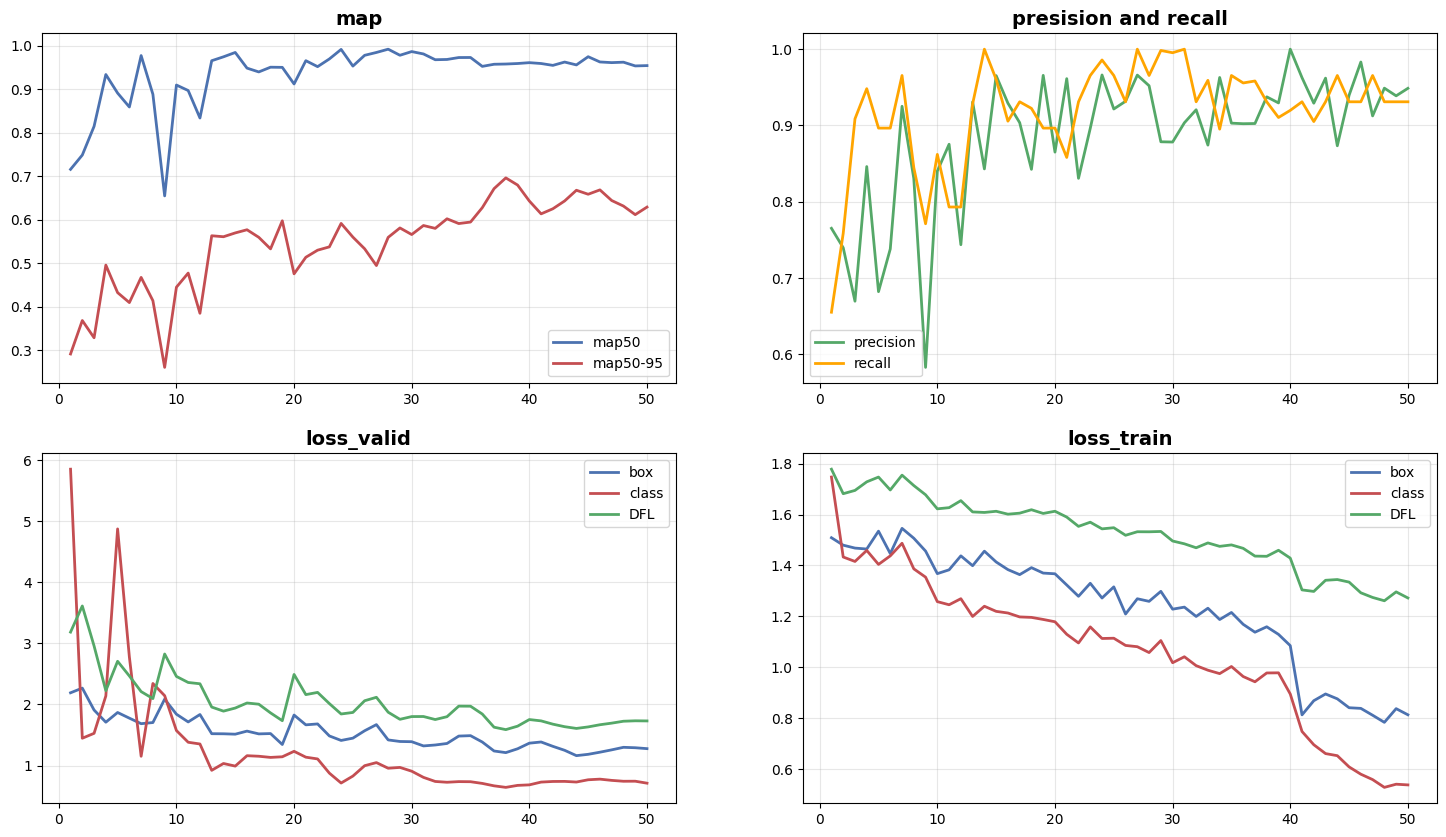

In [95]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(18, 10))


axes[0, 0].plot(df['epoch'], df['metrics/mAP50(B)'], 'b-', linewidth=2, label='map50')
axes[0, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], 'r-', linewidth=2, label='map50-95')
axes[0, 0].set_title('map', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].plot(df['epoch'], df['metrics/precision(B)'], 'g-', linewidth=2, label='precision')
axes[0, 1].plot(df['epoch'], df['metrics/recall(B)'], 'orange', linewidth=2, label='recall')
axes[0, 1].set_title('presision and recall', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)


axes[1, 0].plot(df['epoch'], df['val/box_loss'], 'b-', linewidth=2, label='box')
axes[1, 0].plot(df['epoch'], df['val/cls_loss'], 'r-', linewidth=2, label='class')
axes[1, 0].plot(df['epoch'], df['val/dfl_loss'], 'g-', linewidth=2, label='DFL')
axes[1, 0].set_title('loss_valid', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


axes[1, 1].plot(df['epoch'], df['train/box_loss'], 'b-', linewidth=2, label='box')
axes[1, 1].plot(df['epoch'], df['train/cls_loss'], 'r-', linewidth=2, label='class')
axes[1, 1].plot(df['epoch'], df['train/dfl_loss'], 'g-', linewidth=2, label='DFL')
axes[1, 1].set_title('loss_train', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)


1) map50 стабилизируется к середине обучниея, там же достигнут максимум
2) train и valid loss падают синхронно, нет переобучения 

метрики на тесте:

In [104]:
best = Path('detection/frozen/weights/best.pt')
last = Path('detection/frozen/weights/last.pt')

def testing(m_path):
    m = YOLO(str(m_path))

    test = m.val(
        data='../data/raw/data.yaml',
        split='test',
        device='cpu',
        verbose=False
    )
    
    print(f"  map50: {test.box.map50.item()}")
    print(f"  map50-95: {test.box.map.item()}")
    print(f"  Precision: {test.box.p.item()}")
    print(f"  recall: {test.box.r.item()}")
    
    
testing(best)
testing(last)


Ultralytics YOLOv8.1.0 🚀 Python-3.11.9 torch-2.4.1+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning C:\Users\Professional\detection\data\raw\test\labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


                   all         17         20      0.941       0.85      0.845       0.49
Speed: 1.0ms preprocess, 94.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\val19
  map50: 0.8450880490365402
  map50-95: 0.4901853299047734
  Precision: 0.940779633586766
  recall: 0.85
Ultralytics YOLOv8.1.0 🚀 Python-3.11.9 torch-2.4.1+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning C:\Users\Professional\detection\data\raw\test\labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


                   all         17         20      0.941       0.85      0.919      0.571
Speed: 1.1ms preprocess, 98.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\val20
  map50: 0.9187789987789987
  map50-95: 0.5705613335839902
  Precision: 0.9408298811779745
  recall: 0.85


на тесте лучшие результаты показывает последняя модель

у обеих моделей очень высокая точность, хорошая полнота, но у последней модели на тесте намного выше обе map

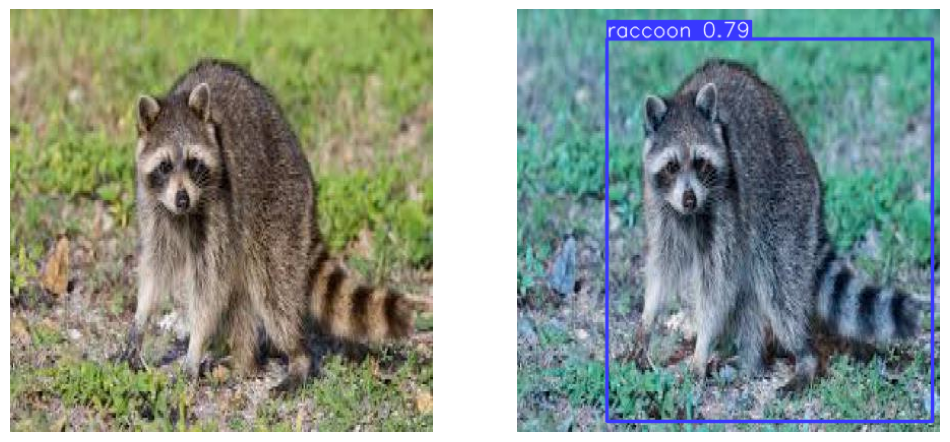

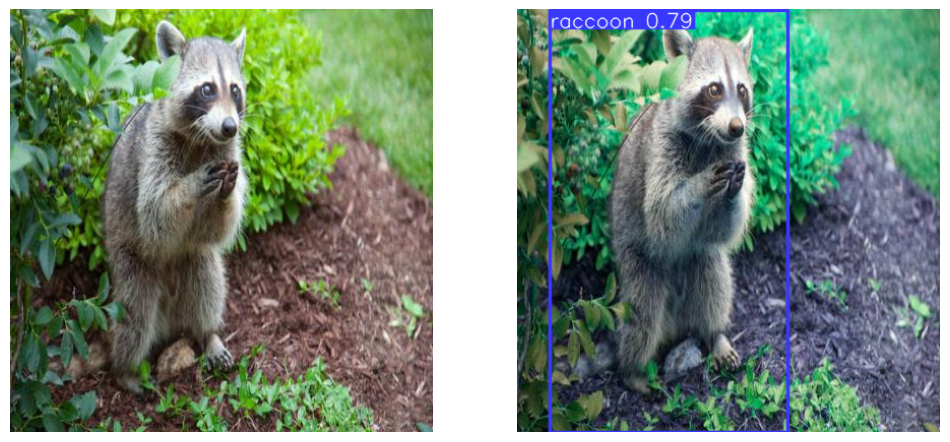

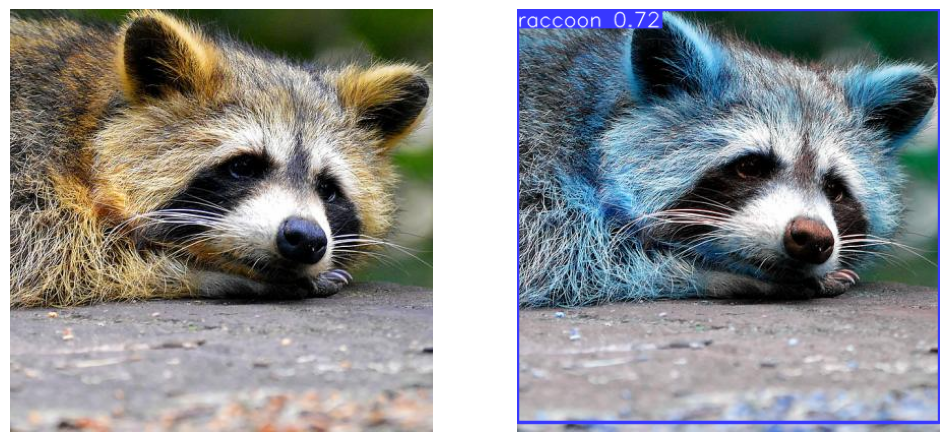

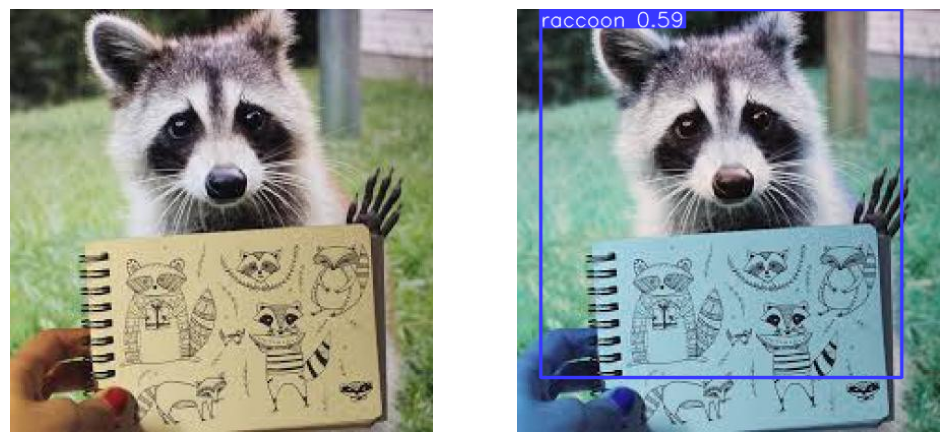

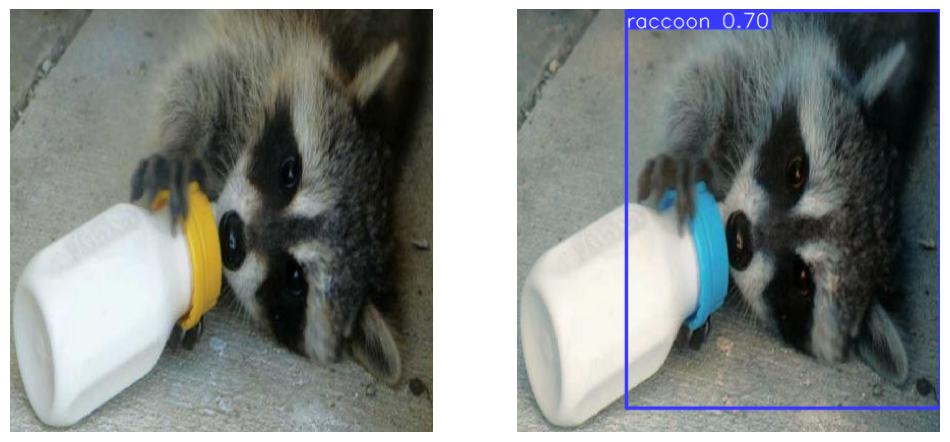

In [107]:
test_folders = [
    '../data/raw/valid/images/',
    '../data/raw/test/images/', 
    '../data/raw/train/images/'
]

test_images = []

for folder in test_folders:
    folder_path = Path(folder)

    files = list(folder_path.glob('*.jpg'))
    for f in files[:5]:
        test_images.append(str(f))
last_m = YOLO(str(last))

if test_images and last.exists():
    for i, img_path in enumerate(test_images[:5]):
        results = last_m.predict(
            source=img_path,
            conf=0.3,  
            iou=0.5,  
            save=False, 
            device='cpu',
            verbose=False
        )
        
        result = results[0]
      
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
        orig_img = Image.open(img_path)
        axes[0].imshow(orig_img)
        axes[0].axis('off')
        
        if hasattr(result, 'plot'):
            det_img = result.plot()  
            axes[1].imshow(det_img)
            axes[1].axis('off')
  